In [1]:
from Bio.PDB import *
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from geometry import position_structure
import freesasa
import numpy as np
import matplotlib.pyplot as plt

import sys
import argparse
import warnings

In [2]:
def parse_PDB(filepath):
    pdb_parser = PDBParser()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', PDBConstructionWarning)
        structure = pdb_parser.get_structure('protein', filepath)

    name = structure.header['name']
    head = structure.header['head']
    filter_words_name = ['pilus', 'pili', 'Pilus', 'Pili', 'PILUS', 'PILI', 'virus', 'Virus', 'VIRUS']
    filter_words_head = ['dna', 'DNA', 'rna', 'RNA']

    if any(word in name for word in filter_words_name) or any(word in head for word in filter_words_head):
        print('Given structure is either a Pilus or Virus protein or contains nucleotides.')
        print('Will not be analysed.')
        return None

    models = [model for model in structure]
    if len(models) > 1:
        model_number = input(str(len(models))+" models found. Please enter model id (1-index): ")
        model = models[int(model_number)-1]
    else:
        model = models[0]
    return model

In [3]:
def position_model(model):
    max_x = -100000
    max_y = -100000
    max_z = -100000
    min_x = 100000
    min_y = 100000
    min_z = 100000
    
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates = atom.coord
                if coordinates[0] > max_x:
                    max_x = coordinates[0]
                if coordinates[1] > max_y:
                    max_y = coordinates[1]
                if coordinates[2] > max_z:
                    max_z = coordinates[2]
                if coordinates[0] < min_x:
                    min_x = coordinates[0]
                if coordinates[1] < min_y:
                    min_y = coordinates[1]
                if coordinates[2] < min_z:
                    min_z = coordinates[2]
    
    model.transform(rot=rotaxis2m(theta=0, vector=Vector(1,0,0)), 
                    tran=-0.5*np.array([max_x + min_x, max_y + min_y, max_z + min_z]))
    ranges = np.array([max_x - 0.5*(max_x + min_x), max_y - 0.5*(max_y + min_y), max_z - 0.5*(max_z + min_z)])

    return model, ranges

In [4]:
def make_slices(model, z_min):
    slices = {}
    for i in range(z_min, -z_min):
        slices[i] = []
    
    
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates = atom.coord
                slices[int(np.floor(atom.coord[2]))].append(atom)
    
    return slices

In [5]:
model = parse_PDB('./structures/pdb1u9j.pdb')
model, ranges = position_model(model)

z_min = int(round(-ranges[2]))

slices = make_slices(model, z_min)



In [6]:
def rectangle(slice_list, z):
    max_x = -1000
    min_x = 1000
    max_y = -1000
    min_y = 1000
    for atom in slice_list:
        coordinates = atom.coord
        if coordinates[0] > max_x:
            max_x = coordinates[0]
        if coordinates[0] < min_x:
            min_x = coordinates[0]
        if coordinates[1] > max_y:
            max_y = coordinates[1]
        if coordinates[1] < min_y:
            min_y = coordinates[1]
    
    print(max_x, min_x, max_y, min_y)
    
    points = []    
    offset = 1
    
    for x in np.linspace(min_x-offset, max_x+offset, int(len(slice_list)/3)):
        points.append(np.array([x, min_y-offset, z]))
        points.append(np.array([x, max_y+offset, z]))
    for y in np.linspace(min_y-offset, max_y+offset, int(len(slice_list)/3)):
        points.append(np.array([min_x-offset, y, z]))
        points.append(np.array([max_x+offset, y, z]))  
    
    return points

In [43]:
def get_outer_atoms(slice_list, rectangle):
    outer_atoms = set()
    outer_atom_ids = []
    
    for point in rectangle:
        current_dists = []
        for atom in slice_list:            
            current_dists.append(np.linalg.norm(point-atom.coord))
        
        outer_atoms.add(slice_list[np.argmin(current_dists)])
    
    for atom in list(outer_atoms):
        outer_atom_ids.append(atom.serial_number)
    
    
    return outer_atoms, outer_atom_ids

28.118995666503906 -26.449003219604492 23.724002838134766 -19.945999145507812


[-30, 30, -30, 30]

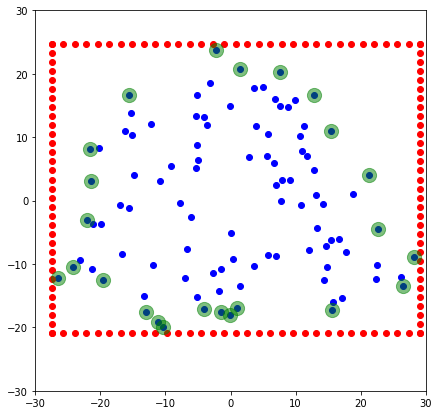

In [44]:
xs = []
ys = []
for atom in slices[0]:
    xs.append(atom.coord[0])
    ys.append(atom.coord[1])
    

xs_rect = []
ys_rect = []
points = rectangle(slices[0], 0 + 0.5)

for point in points:
    xs_rect.append(point[0])
    ys_rect.append(point[1])
    
    
xs_out = []
ys_out = []
outer_atoms, outer_atom_ids = get_outer_atoms(slices[0], points)

for atom in list(outer_atoms):
    xs_out.append(atom.coord[0])
    ys_out.append(atom.coord[1])
    
    
plt.figure(figsize=(7,7))
plt.scatter(xs,ys, color="blue")
plt.scatter(xs_rect, ys_rect, color="red")
plt.scatter(xs_out, ys_out, color="green", s = 200, alpha=0.5)
plt.axis([-30,30,-30,30])

In [62]:
def hydrophobic_factor(slice_list, outer_atom_ids):
    atom_radii = {'C':1.80, 'N':1.60, 'O':1.40, 'S':1.85}
    hydrophobic = ['PHE', 'GLY', 'ILE', 'LEU', 'MET', 'VAL', 'TRP', 'TYR']
    hydrophilic = ['ALA', 'CYS', 'ASP', 'GLU', 'ASN', 'GLN', 'HIS', 'LYS', 'PRO', 'ARG', 'SER', 'THR']
    coord_list = []
    radii_list = []
    for atom in slices[0]:
        coord_list.extend(atom.coord)
        radii_list.append(atom_radii[atom.element])
        
    sasa_result = freesasa.calcCoord(coord_list, radii_list)
    
    total_sasa = 0
    hydrophobic_sasa = 0
    
    for i, atom in enumerate(slices[0]):
        if atom.serial_number in outer_atom_ids:
            res = atom.parent.resname
            if res in hydrophobic or res in hydrophilic:
                total_sasa += sasa_result.atomArea(i)
                if res in hydrophobic:
                    hydrophobic_sasa += sasa_result.atomArea(i)
                    
    return hydrophobic_sasa / total_sasa
    print(total_sasa, hydrophobic_sasa)

In [63]:

hydrophobic_factor(slices[0], outer_atom_ids)
    

1564.9523801275989 402.81449689265736


In [112]:
#for atom in slices[0]:
#    print(atom.parent.id[1], atom.parent.resname, atom.parent.full_id)

residue_dict = {}

for chain in model:
    residue_dict[chain.id] = {}
    for residue in chain:
        #residue_dict[chain.id]
        if residue.id[0] == ' ':
            residue_dict[chain.id][residue.id[1]] = residue['CA']

In [115]:
residue_dict['A'][319-3].coord
residue_dict['A'][319].coord
residue_dict['A'][319+3].coord

array([-6.7060051 , -7.71899796,  0.36499786])

In [133]:
def get_unique_residues_from_slice(slice_list):
    ids = set()
    for atom in slice_list:
        if atom.parent.id[0] == ' ':
            ids.add((atom.parent.parent.id, atom.parent.id[1]))
    return list(ids)

In [135]:
residue_ids = get_unique_residues_from_slice(slices[0])

In [139]:
straight_count = 0
turn_count = 0
endchain_count = 0

vector = np.array([0,0,1])

for chain, resi in residue_ids:
    try:
        prev_res = residue_dict[chain][resi-3].coord
    except KeyError:
        endchain_count += 1
        
    curr_res = residue_dict[chain][resi].coord
    
    try:
        next_res = residue_dict[chain][resi+3].coord
    except KeyError:
        endchain_count += 1
        
    prev_value = np.dot(vector, prev_res)
    curr_value = np.dot(vector, curr_res)
    next_value = np.dot(vector, next_res)
    
    if (prev_value < curr_value and curr_value < next_value) or (prev_value > curr_value and curr_value > next_value):
        straight_count += 1
    else:
        turn_count += 1

straightness_factor = straight_count / len(residue_ids)
turn_factor = 1 - (turn_count / len(residue_ids))
endchain_factor = 1 - (endchain_count / len(residue_ids))

structure_factor = straightness_factor * turn_factor * endchain_factor
print(structure_factor)

0.5216049382716049
